In [107]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.spatial
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import warnings;

warnings.simplefilter('ignore')

# Gradient descent optimization
# The learning rate is specified by eta
class GDOptimizer(object):
    def __init__(self, eta):
        self.eta = eta

    def initialize(self, layers):
        pass

    # This function performs one gradient descent step
    # layers is a list of dense layers in the network
    # g is a list of gradients going into each layer before the nonlinear activation
    # a is a list of of the activations of each node in the previous layer going 
    def update(self, layers, g, a):
        m = a[0].shape[1]
        for layer, curGrad, curA in zip(layers, g, a):
            update = np.dot(curGrad,curA.T)
            updateB = np.sum(curGrad,1).reshape(layer.b.shape)
            layer.updateWeights(-self.eta/m * np.dot(curGrad,curA.T))
            layer.updateBias(-self.eta/m * np.sum(curGrad,1).reshape(layer.b.shape))

# Cost function used to compute prediction errors
class QuadraticCost(object):

    # Compute the squared error between the prediction yp and the observation y
    # This method should compute the cost per element such that the output is the
    # same shape as y and yp
    @staticmethod
    def fx(y,yp):
        return 0.5 * np.square(yp-y)

    # Derivative of the cost function with respect to yp
    @staticmethod
    def dx(y,yp):
        return y - yp

# Sigmoid function fully implemented as an example
class SigmoidActivation(object):
    @staticmethod
    def fx(z):
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def dx(z):
        return SigmoidActivation.fx(z) * (1 - SigmoidActivation.fx(z))
        
# Hyperbolic tangent function
class TanhActivation(object):

    # Compute tanh for each element in the input z
    @staticmethod
    def fx(z):
        return np.tanh(z)

    # Compute the derivative of the tanh function with respect to z
    @staticmethod
    def dx(z):
        return 1 - np.square(np.tanh(z))

# Rectified linear unit
class ReLUActivation(object):
    @staticmethod
    def fx(z):
        return np.maximum(0,z)

    @staticmethod
    def dx(z):
        return (z>0).astype('float')

# Linear activation
class LinearActivation(object):
    @staticmethod
    def fx(z):
        return z

    @staticmethod
    def dx(z):
        return np.ones(z.shape)

# This class represents a single hidden or output layer in the neural network
class DenseLayer(object):

    # numNodes: number of hidden units in the layer
    # activation: the activation function to use in this layer
    def __init__(self, numNodes, activation):
        self.numNodes = numNodes
        self.activation = activation

    def getNumNodes(self):
        return self.numNodes

    # Initialize the weight matrix of this layer based on the size of the matrix W
    def initialize(self, fanIn, scale=1.0):
        s = scale * np.sqrt(6.0 / (self.numNodes + fanIn))
        self.W = np.random.normal(0, s,
                                   (self.numNodes,fanIn))
        #self.b = np.zeros((self.numNodes,1))
        self.b = np.random.uniform(-1,1,(self.numNodes,1))

    # Apply the activation function of the layer on the input z
    def a(self, z):
        return self.activation.fx(z)

    # Compute the linear part of the layer
    # The input a is an n x k matrix where n is the number of samples
    # and k is the dimension of the previous layer (or the input to the network)
    def z(self, a): 
        #print('a:\n'+str(a))
        #print('Wa:\n'+str(self.W.dot(a)))
        return self.W.dot(a) + self.b # Note, this is implemented where we assume a is k x n

    # Compute the derivative of the layer's activation function with respect to z
    # where z is the output of the above function.
    # This derivative does not contain the derivative of the matrix multiplication
    # in the layer.  That part is computed below in the model class.
    def dx(self, z):
        return self.activation.dx(z)

    # Update the weights of the layer by adding dW to the weights
    def updateWeights(self, dW):
        self.W = self.W + dW

    # Update the bias of the layer by adding db to the bias
    def updateBias(self, db):
        self.b = self.b + db

# This class handles stacking layers together to form the completed neural network
class Model(object):

    # inputSize: the dimension of the inputs that go into the network
    def __init__(self, inputSize):
        self.layers = []
        self.inputSize = inputSize

    # Add a layer to the end of the network
    def addLayer(self, layer):
        self.layers.append(layer)

    # Get the output size of the layer at the given index
    def getLayerSize(self, index):
        if index >= len(self.layers):
            return self.layers[-1].getNumNodes()
        elif index < 0:
            return self.inputSize
        else:
            return self.layers[index].getNumNodes()

    # Initialize the weights of all of the layers in the network and set the cost
    # function to use for optimization
    def initialize(self, cost, initializeLayers=True):
        self.cost = cost
        if initializeLayers:
            for i in range(0,len(self.layers)):
                if i == len(self.layers) - 1:
                    self.layers[i].initialize(self.getLayerSize(i-1))
                else:
                    self.layers[i].initialize(self.getLayerSize(i-1))

    # Compute the output of the network given some input a
    # The matrix a has shape n x k where n is the number of samples and
    # k is the dimension
    # This function returns
    # yp - the output of the network
    # a - a list of inputs for each layer of the newtork where
    #     a[i] is the input to layer i
    # z - a list of values for each layer after evaluating layer.z(a) but
    #     before evaluating the nonlinear function for the layer
    def evaluate(self, x):
        curA = x.T
        a = [curA]
        z = []
        for layer in self.layers:
            z.append(layer.z(curA))
            curA = layer.a(z[-1])
            a.append(curA)
        yp = a.pop()
        return yp, a, z

    # Compute the output of the network given some input a
    # The matrix a has shape n x k where n is the number of samples and
    # k is the dimension
    def predict(self, a):
        a,_,_ = self.evaluate(a)
        return a.T

    # Train the network given the inputs x and the corresponding observations y
    # The network should be trained for numEpochs iterations using the supplied
    # optimizer
    def train(self, x, y, numEpochs, optimizer):

        # Initialize some stuff
        n = x.shape[0]
        hist = []
        optimizer.initialize(self.layers)
        
        # Run for the specified number of epochs
        for epoch in range(0,numEpochs):

            # Feed forward
            # Save the output of each layer in the list a
            # After the network has been evaluated, a should contain the
            # input x and the output of each layer except for the last layer
            yp, a, z = self.evaluate(x)

            # Compute the error
            C = self.cost.fx(yp,y.T)
            d = self.cost.dx(yp,y.T)
            grad = []

            # Backpropogate the error
            idx = len(self.layers)
            for layer, curZ in zip(reversed(self.layers),reversed(z)):
                idx = idx - 1
                # Here, we compute dMSE/dz_i because in the update
                # function for the optimizer, we do not give it
                # the z values we compute from evaluating the network
                grad.insert(0,np.multiply(d,layer.dx(curZ)))
                d = np.dot(layer.W.T,grad[0])

            # Update the errors
            optimizer.update(self.layers, grad, a)

            # Compute the error at the end of the epoch
            yh = self.predict(x)
            C = self.cost.fx(yh,y)
            C = np.mean(C)
            hist.append(C)
        return hist

    def trainBatch(self, x, y, batchSize, numEpochs, optimizer):

        # Copy the data so that we don't affect the original one when shuffling
        x = x.copy()
        y = y.copy()
        hist = []
        n = x.shape[0]
        
        for epoch in np.arange(0,numEpochs):
            
            # Shuffle the data
            r = np.arange(0,x.shape[0])
            x = x[r,:]
            y = y[r,:]
            e = []

            # Split the data in chunks and run SGD
            for i in range(0,n,batchSize):
                end = min(i+batchSize,n)
                batchX = x[i:end,:]
                batchY = y[i:end,:]
                e += self.train(batchX, batchY, 1, optimizer)
            hist.append(np.mean(e))

        return hist

def NN_solver(distance, obj_loc):
    x=distance
    y=obj_loc
    xLin=distance
    yHats = {}

    activations = dict(ReLU=ReLUActivation,
                       tanh=TanhActivation,
                       linear=LinearActivation)
    lr = dict(ReLU=0.02,tanh=0.02,linear=0.005)
    names = ['ReLU','linear','tanh']

    for key in ['ReLU']:

        # Build the model
        activation = activations[key]
        model = Model(x.shape[1])
        model.addLayer(DenseLayer(100,activation()))
        model.addLayer(DenseLayer(100,activation()))
        model.addLayer(DenseLayer(2,LinearActivation()))
        model.initialize(QuadraticCost())

        # Train the model and display the results
        hist = model.train(x,y,500,GDOptimizer(eta=lr[key]))
        yHat = model.predict(x)
        yHats[key] = model.predict(xLin)
        squared_diff = np.square(yHat - y)
        error = np.mean(np.sqrt(squared_diff[:, 0] + squared_diff[:, 1]))
        
    return error

    
########################################################################
######### Part b #######################################################
########################################################################

########################################################################
#########  Gradient Computing and MLE ##################################
########################################################################
def compute_gradient_of_likelihood(single_obj_loc, sensor_loc, 
                                single_distance, noise = 1):
    """
    Compute the gradient of the loglikelihood function for part a.   
    
    Input:
    single_obj_loc: 1 * d numpy array. 
    Location of the single object.
    
    sensor_loc: k * d numpy array. 
    Location of sensor.
    
    single_distance: k dimensional numpy array. 
    Observed distance of the object.
    
    Output:
    grad: d-dimensional numpy array.
    
    """
    loc_difference = single_obj_loc - sensor_loc # k * d.
    phi = np.linalg.norm(loc_difference, axis = 1) # k. 
    weight = (phi - single_distance) / phi # k.
    
    grad = -np.sum(np.expand_dims(weight,1)*loc_difference, 
                   axis = 0)/noise ** 2 # d
    return grad 

########################################################################
######### Part c #################################################
########################################################################
def log_likelihood(obj_loc, sensor_loc, distance, noise = 1): 
    """
    This function computes the log likelihood (as expressed in Part a).
    Input: 
    obj_loc: shape [1,2]
    sensor_loc: shape [7,2]
    distance: shape [7]
    Output: 
    The log likelihood function value. 
    """  
    diff_distance = np.sqrt(np.sum((sensor_loc - obj_loc)**2, axis = 1))- distance
    func_value = -sum((diff_distance)**2)/(2 * noise ** 2)
    return func_value
 


########################################################################
######### Part e, f, g #################################################
########################################################################

########################################################################
#########  Gradient Computing and MLE ##################################
########################################################################
def compute_grad_likelihood_part_e(sensor_loc, obj_loc, distance, noise = 1):
    """
    Compute the gradient of the loglikelihood function for part d.   
    
    Input:
    sensor_loc: k * d numpy array. 
    Location of sensors.
    
    obj_loc: n * d numpy array. 
    Location of the objects.
    
    distance: n * k dimensional numpy array. 
    Observed distance of the object.
    
    Output:
    grad: k * d numpy array.
    """
    grad = np.zeros(sensor_loc.shape)
    for i, single_sensor_loc in enumerate(sensor_loc):
        single_distance = distance[:,i] 
        grad[i] = compute_gradient_of_likelihood(single_sensor_loc, 
                     obj_loc, single_distance, noise)
        
    return grad

def find_mle_by_grad_descent_part_e(initial_sensor_loc, 
           obj_loc, distance, noise = 1, lr=0.001, num_iters = 1000):
    """
    Compute the gradient of the loglikelihood function for part a.   
    
    Input:
    initial_sensor_loc: k * d numpy array. 
    Initialized Location of the sensors.
    
    obj_loc: n * d numpy array. Location of the n objects.
    
    distance: n * k dimensional numpy array. 
    Observed distance of the n object.
    
    Output:
    sensor_loc: k * d numpy array. The mle for the location of the object.
    
    """    
    sensor_loc = initial_sensor_loc
    for t in range(num_iters):
        sensor_loc += lr * compute_grad_likelihood_part_e(\
            sensor_loc, obj_loc, distance, noise) 
        
    return sensor_loc 
 
 ########################################################################
#########  Estimate distance given estimated sensor locations. ######### 
########################################################################

def compute_distance_with_sensor_and_obj_loc(sensor_loc, obj_loc):
    """
    stimate distance given estimated sensor locations.  
    
    Input:
    sensor_loc: k * d numpy array. 
    Location of the sensors.
    
    obj_loc: n * d numpy array. Location of the n objects.
    
    Output:
    distance: n * k dimensional numpy array. 
    """ 
    estimated_distance = scipy.spatial.distance.cdist(obj_loc, 
                                            sensor_loc, 
                                            metric='euclidean')
    return estimated_distance 
 
########################################################################
#########  Data Generating Functions ###################################
########################################################################

def generate_sensors(num_sensors = 7, spatial_dim = 2):
    """
    Generate sensor locations. 
    Input:
    num_sensors: The number of sensors.
    spatial_dim: The spatial dimension.
    Output:
    sensor_loc: num_sensors * spatial_dim numpy array.
    """
    sensor_loc = 100*np.random.randn(num_sensors,spatial_dim)
    return sensor_loc

def generate_dataset(sensor_loc, num_sensors = 7, spatial_dim = 2, 
                 num_data = 1, original_dist = True, noise = 1):
    """
    Generate the locations of n points.  

    Input:
    sensor_loc: num_sensors * spatial_dim numpy array. Location of sensor. 
    num_sensors: The number of sensors.
    spatial_dim: The spatial dimension.
    num_data: The number of points.
    original_dist: Whether the data are generated from the original 
    distribution. 

    Output:
    obj_loc: num_data * spatial_dim numpy array. The location of the num_data objects. 
    distance: num_data * num_sensors numpy array. The distance between object and 
    the num_sensors sensors. 
    """
    assert num_sensors, spatial_dim == sensor_loc.shape

    obj_loc = 100*np.random.randn(num_data, spatial_dim)
    if not original_dist:
       obj_loc += 1000

    distance = scipy.spatial.distance.cdist(obj_loc, 
                                           sensor_loc, 
                                           metric='euclidean')
    distance += np.random.randn(num_data, num_sensors) * noise
    return distance, obj_loc

def GM_solver(distance, obj_loc):
    initial_sensor_loc = np.zeros((7,2)) #np.random.randn(7,2)
    estimated_sensor_loc = find_mle_by_grad_descent_part_e(initial_sensor_loc, 
               obj_loc, distance, lr=0.001, num_iters = 1000)
    estimated_obj_loc = np.zeros((n, 2))
    for j in range(n):
        initial_obj_loc = np.random.randn(1,2)
        estimated_obj_loc[j, :] = find_mle_by_grad_descent_part_b(initial_obj_loc, 
               estimated_sensor_loc, distance[j, :], lr=0.001, num_iters = 1000)
    squared_diff = (estimated_obj_loc - obj_loc) ** 2
    return np.mean(np.sqrt(squared_diff[:, 0] + squared_diff[:, 1]))

#########
## OLS ##
#########

def OLS(X, y):
	return np.matmul( np.linalg.inv( np.matmul(X.T, X) ), np.matmul(X.T, y) )


def OLS_err(coeffs, X, y):
    yp = X.dot(coeffs)
    squared_diff = (yp - y) ** 2
    return np.mean(np.sqrt(squared_diff[:, 0] + squared_diff[:, 1]))

def OLS_polynomial_solver(d, X, y):
    n, m = X.shape   # n = 1000, m = 7
    X_new = X
    for i in range(2, d + 1):
        X_new = np.append(X_new, X ** i, axis=1)
    X_new = np.append(np.ones((n, 1)), X_new, axis=1)
    coeffs = OLS(X_new, y)
    err = OLS_err(coeffs, X_new, y)
    return coeffs, err   


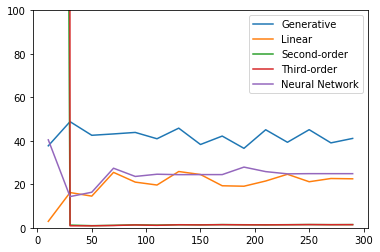

In [108]:
##########
## main ##
##########

# 4(b).1

n_train = range(10, 291, 20)

sensor_loc = generate_sensors()
errors = np.zeros( (15, 5), "float" )
np.random.seed(0)
for i, n in enumerate(n_train):
    distance, obj_loc = generate_dataset(sensor_loc, num_data=n)
    # Generative Model
    errors[i, 0] = GM_solver(distance, obj_loc)
    # OLS Linear:
    _, errors[i, 1] = OLS_polynomial_solver(1, distance, obj_loc)
    # OLS Second-order
    _, errors[i, 2] = OLS_polynomial_solver(2, distance, obj_loc)
    # OLS Third-order
    _, errors[i, 3] = OLS_polynomial_solver(3, distance, obj_loc)
    # Neural Network Model
    errors[i, 4] = NN_solver(distance, obj_loc)
        
plt.figure()
plt.plot(n_train, errors[:, 0], label="Generative")
plt.plot(n_train, errors[:, 1], label="Linear")
plt.plot(n_train, errors[:, 2], label="Second-order")
plt.plot(n_train, errors[:, 3], label="Third-order")
plt.plot(n_train, errors[:, 4], label="Neural Network")
plt.ylim((0, 100))
plt.legend(loc="best")
plt.show()
    

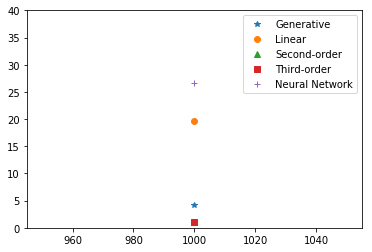

In [116]:
##########
## main ##
##########

# 4(b).2

n_test = [1000]

sensor_loc = generate_sensors()
errors = np.zeros( (1, 5), "float" )
np.random.seed(0)
for i, n in enumerate(n_test):
    distance, obj_loc = generate_dataset(sensor_loc, num_data=n)
    # Generative Model
    errors[i, 0] = GM_solver(distance, obj_loc)
    # OLS Linear:
    _, errors[i, 1] = OLS_polynomial_solver(1, distance, obj_loc)
    # OLS Second-order
    _, errors[i, 2] = OLS_polynomial_solver(2, distance, obj_loc)
    # OLS Third-order
    _, errors[i, 3] = OLS_polynomial_solver(3, distance, obj_loc)
    # Neural Network Model
    errors[i, 4] = NN_solver(distance, obj_loc)
        
plt.figure()
plt.plot(n_test, errors[:, 0], "*", label="Generative")
plt.plot(n_test, errors[:, 1], "o", label="Linear")
plt.plot(n_test, errors[:, 2], "^", label="Second-order")
plt.plot(n_test, errors[:, 3], "s", label="Third-order")
plt.plot(n_test, errors[:, 4], "+", label="Neural Network")
plt.ylim((0, 40))
plt.legend(loc="best")
plt.show()


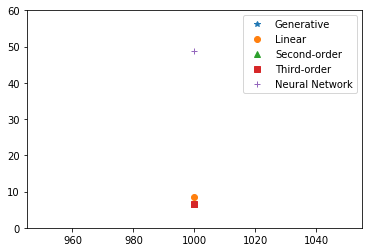

In [118]:
##########
## main ##
##########

# 4(b).3

n_test = [1000]

sensor_loc = generate_sensors()
errors = np.zeros( (1, 5), "float" )
np.random.seed(0)
for i, n in enumerate(n_test):
    distance, obj_loc = generate_dataset(sensor_loc, num_data=n, original_dist=False)
    # Generative Model
    errors[i, 0] = GM_solver(distance, obj_loc)
    # OLS Linear:
    _, errors[i, 1] = OLS_polynomial_solver(1, distance, obj_loc)
    # OLS Second-order
    _, errors[i, 2] = OLS_polynomial_solver(2, distance, obj_loc)
    # OLS Third-order
    _, errors[i, 3] = OLS_polynomial_solver(3, distance, obj_loc)
    # Neural Network Model
    errors[i, 4] = NN_solver(distance, obj_loc)
        
plt.figure()
plt.plot(n_test, errors[:, 0], "*", label="Generative")
plt.plot(n_test, errors[:, 1], "o", label="Linear")
plt.plot(n_test, errors[:, 2], "^", label="Second-order")
plt.plot(n_test, errors[:, 3], "s", label="Third-order")
plt.plot(n_test, errors[:, 4], "+", label="Neural Network")
plt.ylim((0, 60))
plt.legend(loc="best")
plt.show()

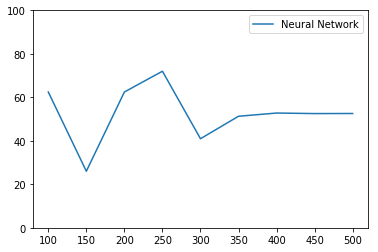

In [134]:
##########
## main ##
##########

# 4(c)

def NN_solver_tune_1(l, distance, obj_loc, distance_test, obj_loc_test):
    x=distance
    y=obj_loc
    xtest=distance_test
    ytest=obj_loc

    activations = dict(ReLU=ReLUActivation,
                       tanh=TanhActivation,
                       linear=LinearActivation)
    lr = dict(ReLU=0.02,tanh=0.02,linear=0.005)
    names = ['ReLU','linear','tanh']

    for key in ['ReLU']:

        # Build the model
        activation = activations[key]
        model = Model(x.shape[1])
        model.addLayer(DenseLayer(l,activation()))
        model.addLayer(DenseLayer(l,activation()))
        model.addLayer(DenseLayer(2,LinearActivation()))
        model.initialize(QuadraticCost())

        # Train the model and display the results
        hist = model.train(x,y,500,GDOptimizer(eta=lr[key]))
        yHat = model.predict(x)
        squared_diff = np.square(yHat - y)
        error = np.mean(np.sqrt(squared_diff[:, 0] + squared_diff[:, 1]))
        
    return error

l = range(100, 501, 50)
n_train = 200
n_test = 1000
errors = np.zeros( (len(l),), "float")

sensor_loc = generate_sensors()
np.random.seed(9001)
for i, ll in enumerate(l):
    distance, obj_loc = generate_dataset(sensor_loc, num_data=n_train)
    distance_test, obj_loc_test = generate_dataset(sensor_loc, num_data=n_test)
    # Neural Network Model
    errors[i] = NN_solver_tune_1(ll, distance, obj_loc, distance_test, obj_loc_test)
    mm = np.mean(errors[:i-1])
        
plt.figure()
plt.plot(l, errors, label="Neural Network")
plt.ylim((0, 100))
plt.legend(loc="best")
plt.show()

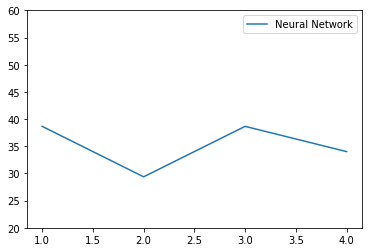

In [141]:
##########
## main ##
##########

# 4(d)

def NN_solver_tune_2(k, l, distance, obj_loc, distance_test, obj_loc_test):
    x=distance
    y=obj_loc
    xtest=distance_test
    ytest=obj_loc

    activations = dict(ReLU=ReLUActivation,
                       tanh=TanhActivation,
                       linear=LinearActivation)
    lr = dict(ReLU=0.02,tanh=0.02,linear=0.005)
    names = ['ReLU','linear','tanh']

    for key in ['ReLU']:

        # Build the model
        activation = activations[key]
        model = Model(x.shape[1])
        for _ in range(k):
            model.addLayer(DenseLayer(l,activation()))
        model.addLayer(DenseLayer(2,LinearActivation()))
        model.initialize(QuadraticCost())

        # Train the model and display the results
        hist = model.train(x,y,500,GDOptimizer(eta=lr[key]))
        yHat = model.predict(x)
        squared_diff = np.square(yHat - y)
        error = np.mean(np.sqrt(squared_diff[:, 0] + squared_diff[:, 1]))
        
    return error

k = range(1, 5)
n_train = 200
n_test = 200
errors = np.zeros( (len(k),), "float")

sensor_loc = generate_sensors()
np.random.seed(9001)
for i, kk in enumerate(k):
    if kk == 1:
        ll = 1000
    elif kk == 2:
        ll = 95
    elif kk == 3:
        ll = 67
    else:
        ll = 55
    distance, obj_loc = generate_dataset(sensor_loc, num_data=n_train)
    distance_test, obj_loc_test = generate_dataset(sensor_loc, num_data=n_test)
    # Neural Network Model
    errors[i] = NN_solver_tune_2(kk, ll, distance, obj_loc, distance_test, obj_loc_test)
    mm = np.mean(errors[:i-1])
        
plt.figure()
plt.plot(k, errors, label="Neural Network")
plt.ylim((20, 60))
plt.legend(loc="best")
plt.show()

In [147]:
##########
## main ##
##########

k = 2
l = 150

# 4(e)
sensor_loc = generate_sensors()
np.random.seed(9001)
n_train = 200
n_test = 1000
distance, obj_loc = generate_dataset(sensor_loc, num_data=n_train)
error = NN_solver_tune_2(k, l, distance, obj_loc, distance_test, obj_loc_test)
print(error)


15.201287385073272


In [146]:
## Problem 5

# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""A very simple MNIST classifier.

See extensive documentation at
https://www.tensorflow.org/get_started/mnist/beginners
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys

from tensorflow.examples.tutorials.mnist import input_data

import tensorflow as tf

FLAGS = None


def main(_):
  # Import data
  mnist = input_data.read_data_sets(FLAGS.data_dir, one_hot=True)

  # Create the model
  x = tf.placeholder(tf.float32, [None, 784])
  W = tf.Variable(tf.zeros([784, 10]))
  b = tf.Variable(tf.zeros([10]))
  y = tf.matmul(x, W) + b

  # Define loss and optimizer
  y_ = tf.placeholder(tf.float32, [None, 10])

  # The raw formulation of cross-entropy,
  #
  #   tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(tf.nn.softmax(y)),
  #                                 reduction_indices=[1]))
  #
  # can be numerically unstable.
  #
  # So here we use tf.nn.softmax_cross_entropy_with_logits on the raw
  # outputs of 'y', and then average across the batch.
  cross_entropy = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
  train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

  sess = tf.InteractiveSession()
  tf.global_variables_initializer().run()
  # Train
  for _ in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

  # Test trained model
  correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  print(sess.run(accuracy, feed_dict={x: mnist.test.images,
                                      y_: mnist.test.labels}))

if __name__ == '__main__':
  parser = argparse.ArgumentParser()
  parser.add_argument('--data_dir', type=str, default='/tmp/tensorflow/mnist/input_data',
                      help='Directory for storing input data')
  FLAGS, unparsed = parser.parse_known_args()
  tf.app.run(main=main, argv=[sys.argv[0]] + unparsed)


Extracting /tmp/tensorflow/mnist/input_data\train-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data\train-labels-idx1-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data\t10k-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data\t10k-labels-idx1-ubyte.gz
0.9218


SystemExit: 